In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

In [2]:
tk = th.Thicket.from_caliperreader("cali")

(2/2) Creating Thicket: 100%|██████████| 243/243 [00:08<00:00, 27.23it/s]


In [3]:
df = tk.dataframe

In [4]:
comp_large_df = tk.dataframe[tk.dataframe['name'] == 'comp_large']
# print(comm_large_df)

comm_df = tk.dataframe[tk.dataframe['name'] == 'comm']
# print(comm_df)

main_df = tk.dataframe[tk.dataframe['name'] == 'main']
print(main_df)


                                                 nid   spot.channel  \
node                                 profile                          
{'name': 'main', 'type': 'function'} 27829077    1.0  regionprofile   
                                     30558843    1.0  regionprofile   
                                     53503295    1.0  regionprofile   
                                     82647496    1.0  regionprofile   
                                     88614086    1.0  regionprofile   
...                                              ...            ...   
                                     4194353103  2.0  regionprofile   
                                     4197493351  2.0  regionprofile   
                                     4240018986  2.0  regionprofile   
                                     4268328121  2.0  regionprofile   
                                     4286169422  2.0  regionprofile   

                                                 Min time/rank  Max time/ran

In [5]:
tk.show_metric_columns()

['Total time',
 'Min time/rank',
 'Variance time/rank',
 'Calls/rank (min)',
 'Min time/rank (exc)',
 'Max time/rank (exc)',
 'Total time (exc)',
 'Avg time/rank',
 'Calls/rank (avg)',
 'Calls/rank (max)',
 'Max time/rank',
 'Avg time/rank (exc)',
 'Calls/rank (total)']

In [6]:
import colorama
colorama.init()

raw_output = tk.tree(metric_column = "Max time/rank")

import re
clean_output = re.sub(r'\x1b\[[0-9;]*m', '', raw_output)
print(clean_output)

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

13.778 main
├─ 0.894 MPI_Comm_dup
├─ 0.001 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Initialized
└─ 13.764 main
   ├─ 0.000 MPI_Init
   ├─ 0.995 comm
   │  └─ 0.995 comm_large
   │     ├─ 0.112 MPI_Gather
   │     └─ 0.888 MPI_Scatter
   ├─ 10.404 comp
   │  └─ 10.404 comp_large
   │     ├─ nan MPI_Barrier
   │     ├─ nan comm
   │     │  └─ nan comm_small
   │     │     └─ nan MPI_Sendrecv
   │     ├─ nan comp
   │     │  ├─ nan comp_large
   │     │  └─ nan comp_small
   │     └─ 10.357 comp_small
   │        ├─ 4.853 MPI_Barrier
   │        └─ 9.917 comm_small
   │           └─ 0.253 MPI_Sendrecv
   ├─ 0.771 correctness_check
   └─ 0.720 data_init_runtime

Legend (Metric: Max time/rank Min: 0.00 Max: 13.78 indices: {'profile': 27829077})
█ 12.40 - 13.78
█ 9.64 - 12.40
█ 6.89 - 9.64
█ 4.13 - 6

In [7]:
metadata_df = tk.metadata

In [8]:
import pandas as pd

merged_df = metadata_df.merge(
    comm_df[['Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']],  # Select the necessary columns from comp_large_df
    left_index=True, 
    right_index=True,
    how='inner'  # Keep only matching profiles
)

comm_final_df = merged_df[['input_size', 'input_type', 'num_procs', 'Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']]

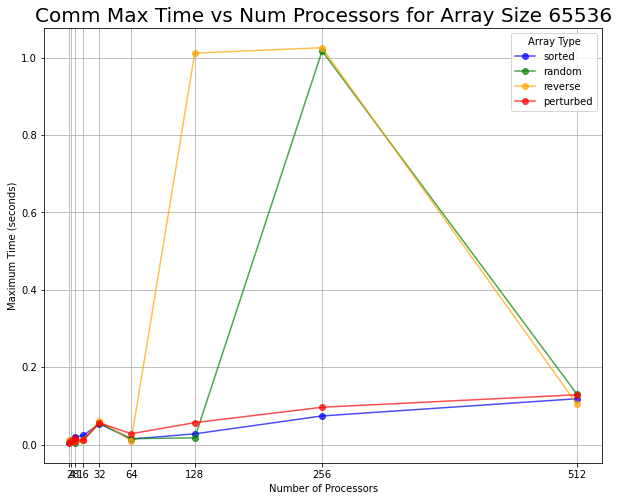

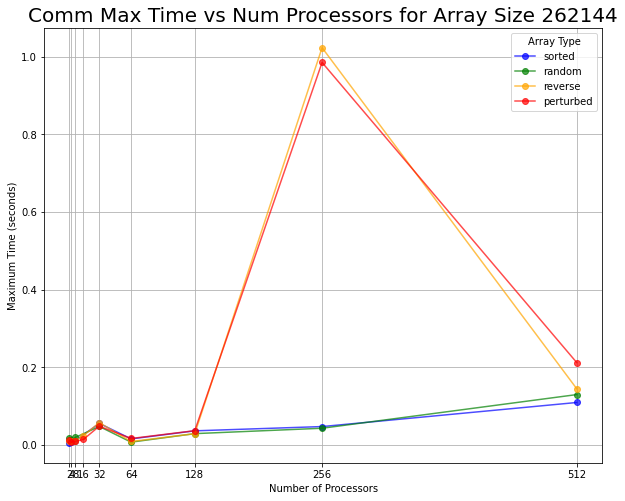

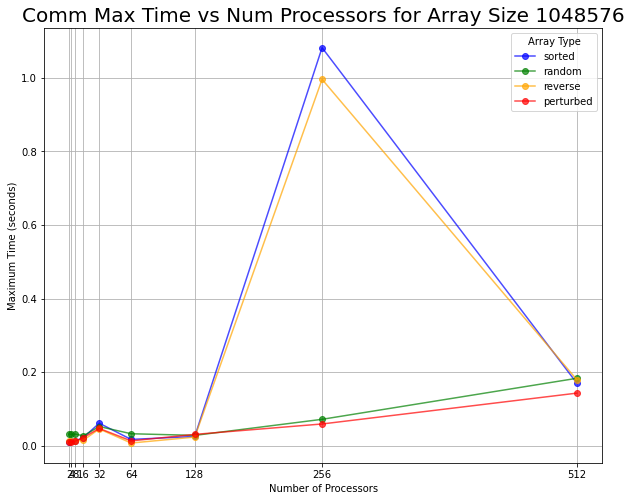

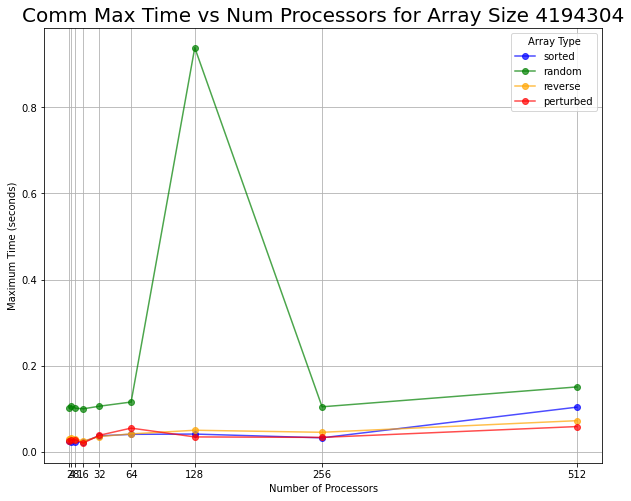

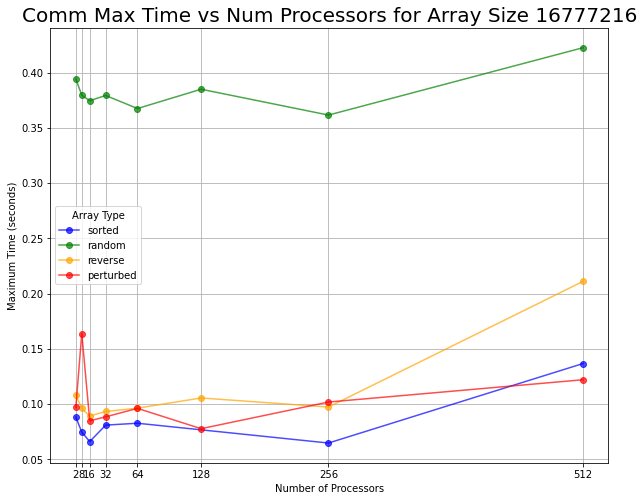

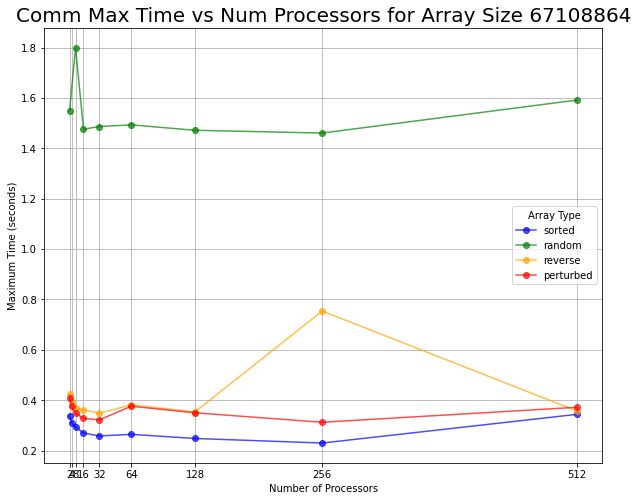

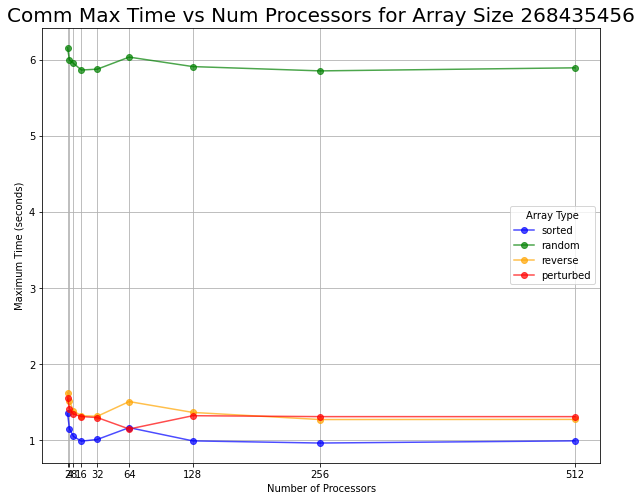

In [9]:
# Comm - strong scaling

import pandas as pd
import matplotlib.pyplot as plt


array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for array_size in array_sizes:

    filtered_df = comm_final_df[comm_final_df['input_size'] == array_size]


    colors = {
        'sorted': 'blue',
        'random': 'green',
        'reverse': 'orange',
        'perturbed': 'red'
    }


    plt.figure(figsize=(10, 8))

    
    for array_type, color in colors.items():
        type_data = filtered_df[filtered_df['input_type'] == array_type]

        type_data = type_data.sort_values('num_procs')

        plt.plot(type_data['num_procs'], type_data['Max time/rank'], 
                 color=color, label=array_type, alpha=0.7, marker='o') 

    plt.title(f'Comm Max Time vs Num Processors for Array Size {array_size}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Maximum Time (seconds)')
    plt.xticks(filtered_df['num_procs'].unique())
    plt.grid()
    plt.legend(title='Array Type')
    plt.savefig(f'img/comm_strong_max_{array_size}.png', facecolor='white')
    plt.show()


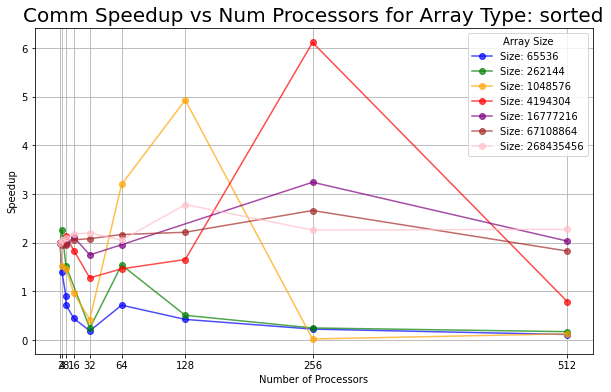

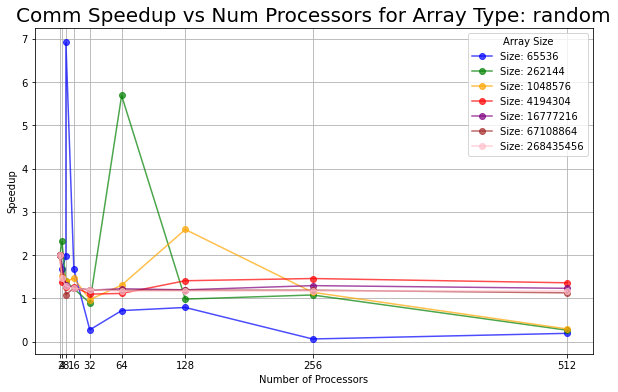

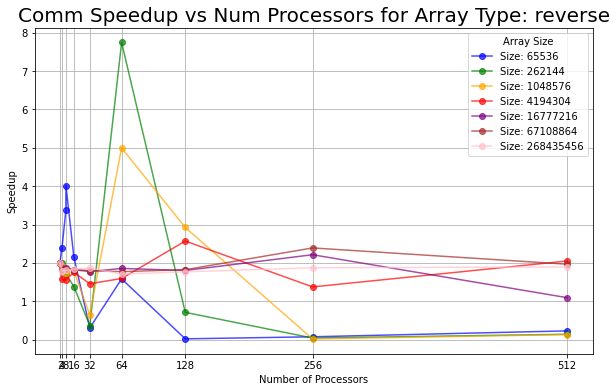

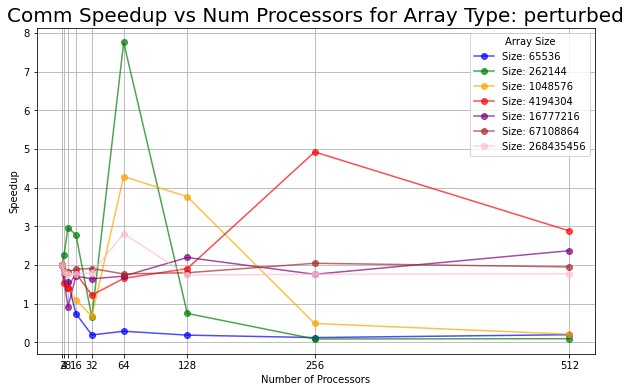

In [10]:
# Comm - strong scaling speedup

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [2**i for i in range(16, 29)] 
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}


speedup_df = pd.DataFrame()

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = comm_final_df[comm_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue
        
        single_proc_time = type_data[type_data['num_procs'] == 2]['Avg time/rank'].mean() * 2
        if pd.isna(single_proc_time):
            continue
        
        type_data.loc[:, 'Speedup'] = single_proc_time / type_data['Avg time/rank'] 
        
        speedup_df = pd.concat([speedup_df, type_data])
        
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Speedup'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o')  

    plt.title(f'Comm Speedup vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Speedup')
    plt.xticks(sorted(type_data['num_procs'].unique()))  
    plt.grid()
    plt.legend(title='Array Size')  
    plt.savefig(f'img/comm_speedup_avg_{array_type}.png', facecolor='white')
    plt.show() 



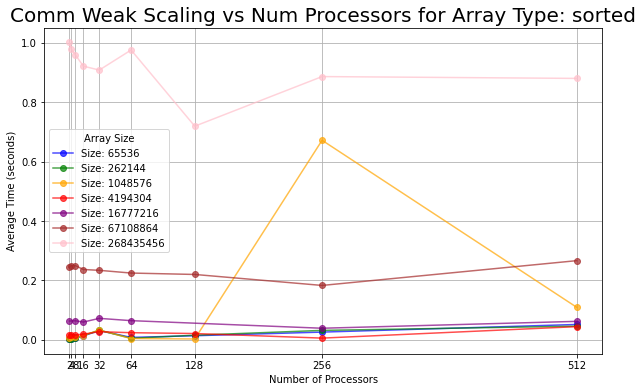

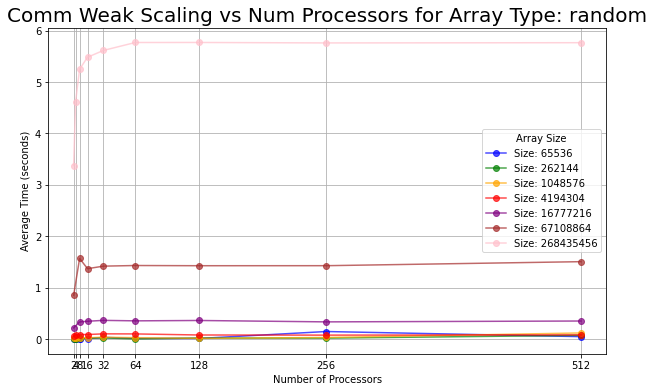

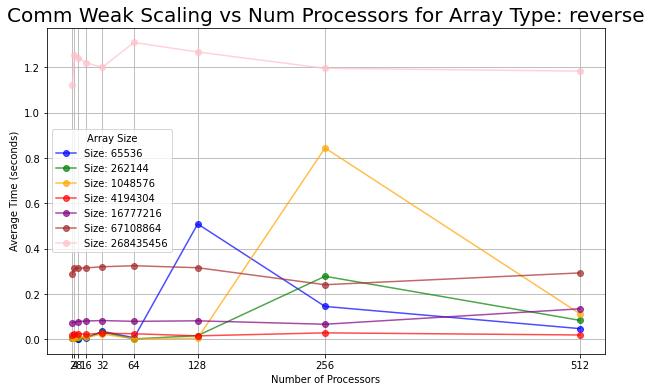

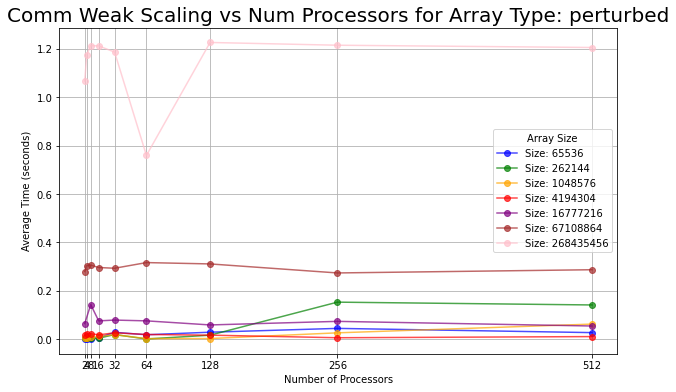

In [11]:
# Comm - weak scaling

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = comm_final_df[comm_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue 
        
    
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Avg time/rank'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o') 

    plt.title(f'Comm Weak Scaling vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(sorted(type_data['num_procs'].unique()))
    plt.grid()
    plt.legend(title='Array Size') 
    plt.savefig(f'img/comm_weak_avg_{array_type}.png', facecolor='white')
    plt.show() 


In [12]:
import pandas as pd

merged_df = metadata_df.merge(
    comp_large_df[['Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']],  # Select the necessary columns from comp_large_df
    left_index=True, 
    right_index=True,
    how='inner'  # Keep only matching profiles
)

comp_large_final_df = merged_df[['input_size', 'input_type', 'num_procs', 'Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']]

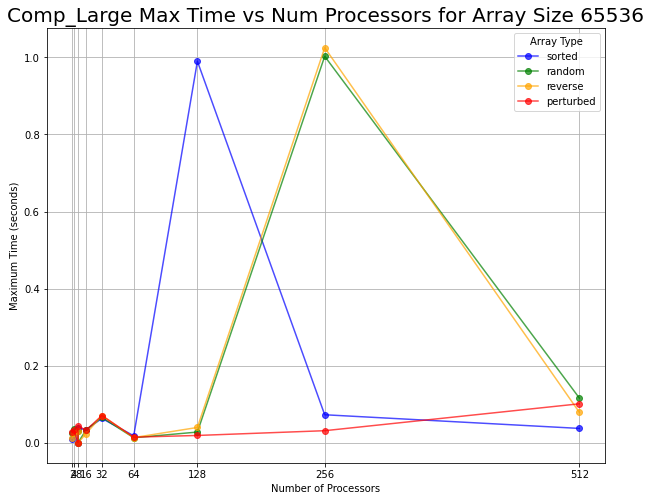

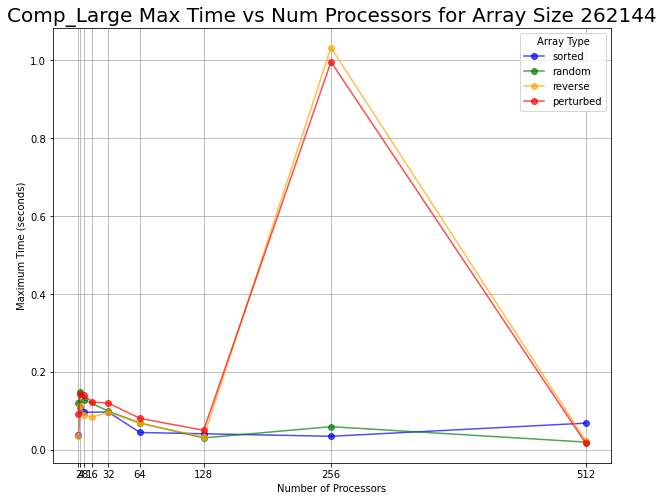

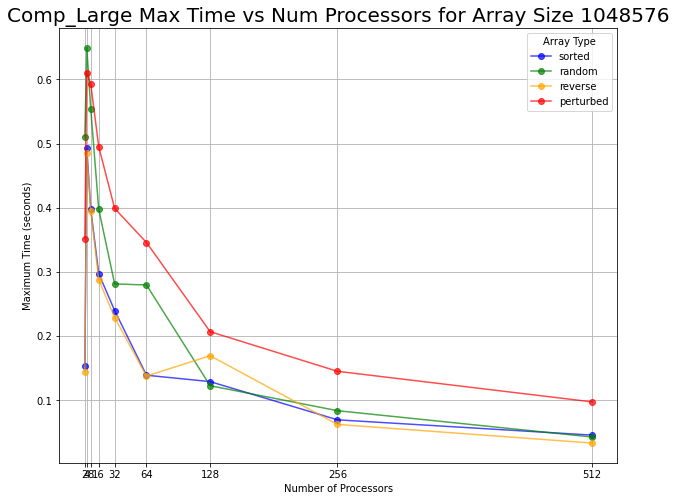

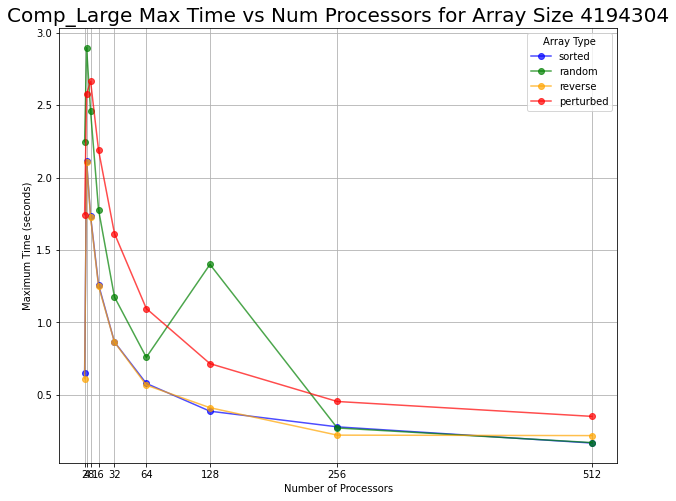

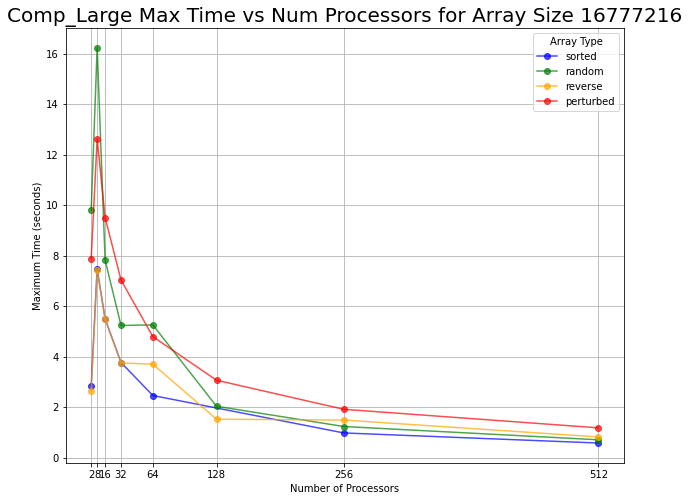

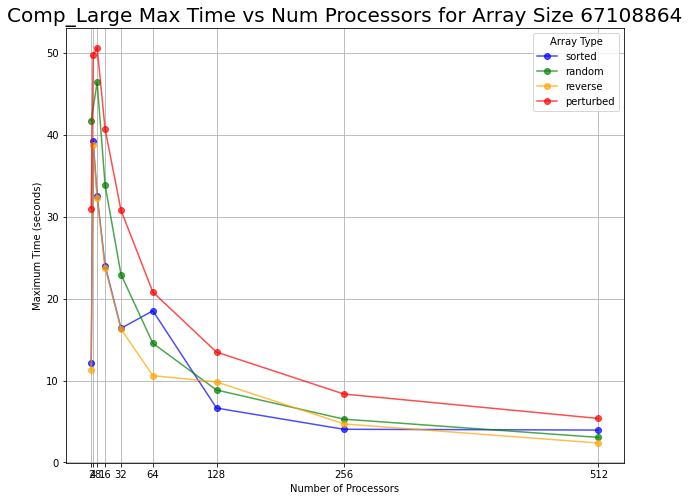

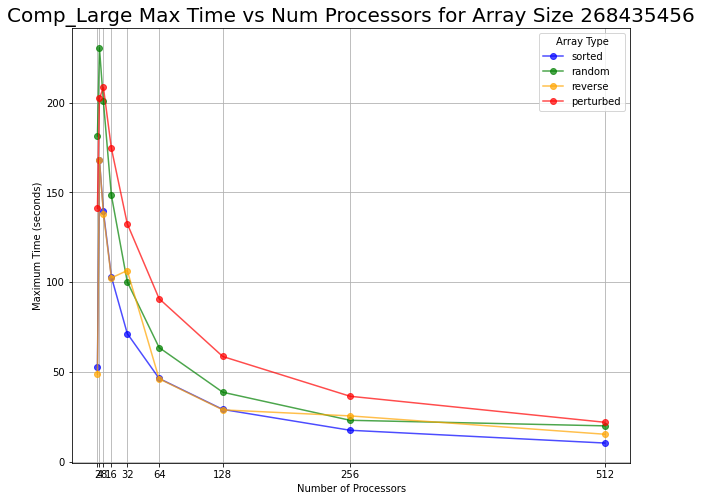

In [13]:
# Comp Large - strong scaling

import pandas as pd
import matplotlib.pyplot as plt


array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for array_size in array_sizes:

    filtered_df = comp_large_final_df[comp_large_final_df['input_size'] == array_size]


    colors = {
        'sorted': 'blue',
        'random': 'green',
        'reverse': 'orange',
        'perturbed': 'red'
    }


    plt.figure(figsize=(10, 8))

    
    for array_type, color in colors.items():
        type_data = filtered_df[filtered_df['input_type'] == array_type]

        type_data = type_data.sort_values('num_procs')

        plt.plot(type_data['num_procs'], type_data['Max time/rank'], 
                 color=color, label=array_type, alpha=0.7, marker='o') 

    plt.title(f'Comp_Large Max Time vs Num Processors for Array Size {array_size}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Maximum Time (seconds)')
    plt.xticks(filtered_df['num_procs'].unique())
    plt.grid()
    plt.legend(title='Array Type')
    plt.savefig(f'img/comp_strong_max_{array_size}.png', facecolor='white')
    plt.show()


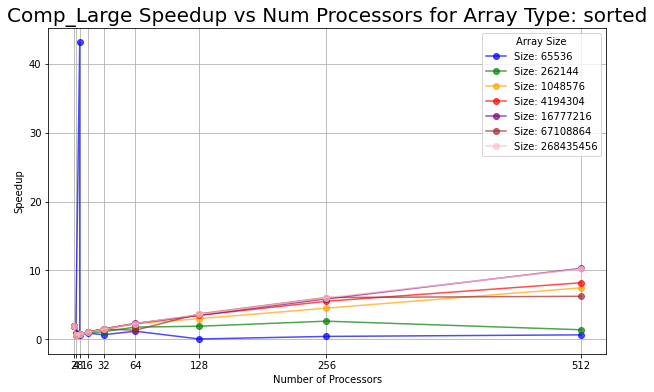

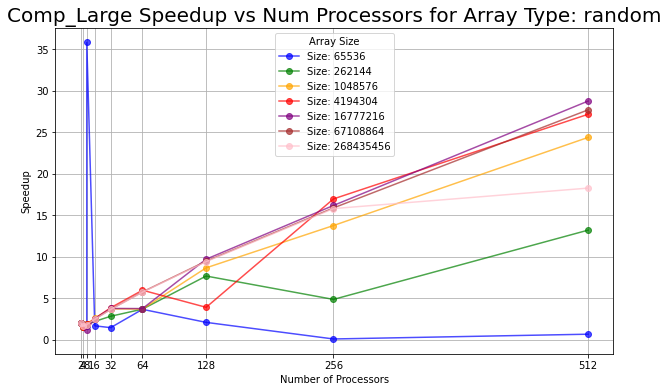

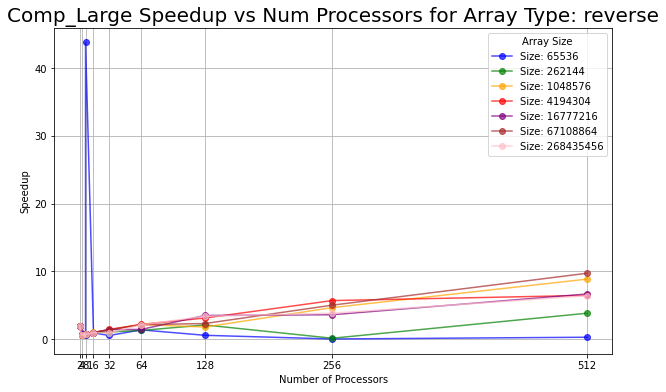

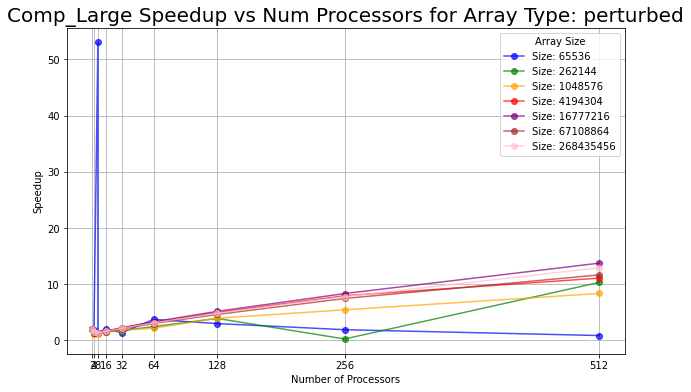

In [14]:
# Comp large - strong scaling speedup

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [2**i for i in range(16, 29)] 
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}


speedup_df = pd.DataFrame()

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = comp_large_final_df[comp_large_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue
        
        single_proc_time = type_data[type_data['num_procs'] == 2]['Avg time/rank'].mean() * 2
        if pd.isna(single_proc_time):
            continue
        
        type_data.loc[:, 'Speedup'] = single_proc_time / type_data['Avg time/rank'] 
        
        speedup_df = pd.concat([speedup_df, type_data])
        
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Speedup'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o')  

    plt.title(f'Comp_Large Speedup vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Speedup')
    plt.xticks(sorted(type_data['num_procs'].unique()))  
    plt.grid()
    plt.legend(title='Array Size')  
    plt.savefig(f'img/comp_speedup_avg_{array_type}.png', facecolor='white')
    plt.show() 



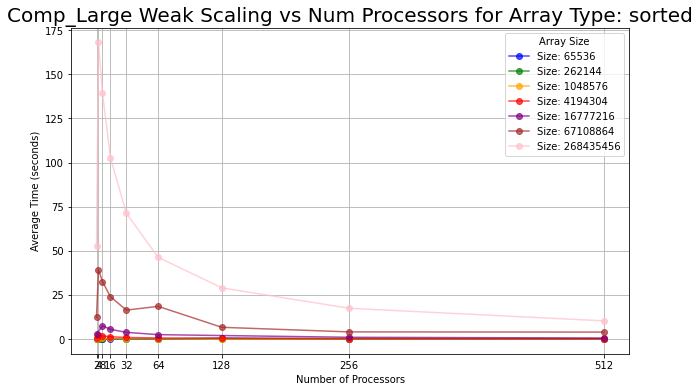

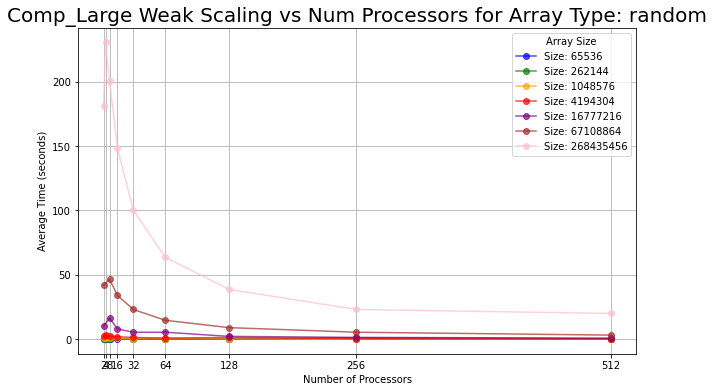

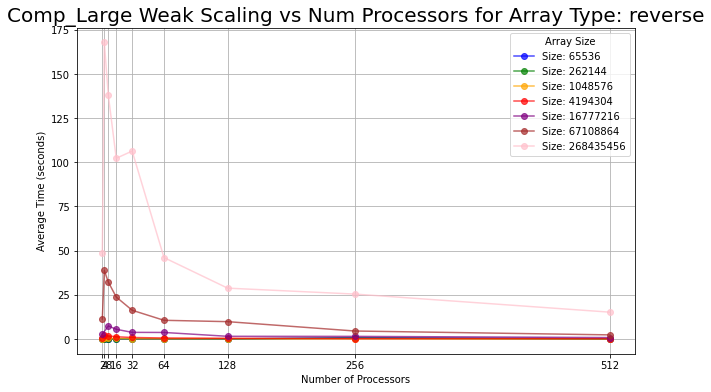

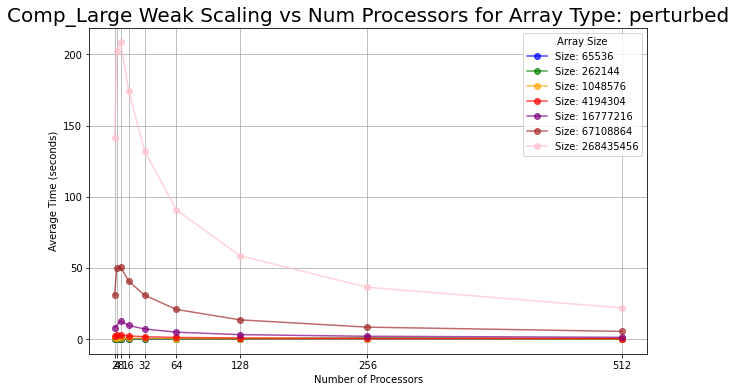

In [15]:
# Comp Large - weak scaling

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = comp_large_final_df[comp_large_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue 
        
    
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Avg time/rank'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o') 

    plt.title(f'Comp_Large Weak Scaling vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(sorted(type_data['num_procs'].unique()))
    plt.grid()
    plt.legend(title='Array Size') 
    plt.savefig(f'img/comp_weak_avg_{array_type}.png', facecolor='white')
    plt.show() 


In [16]:
import pandas as pd

merged_df = metadata_df.merge(
    main_df[['Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']],  # Select the necessary columns from comp_large_df
    left_index=True, 
    right_index=True,
    how='inner'  # Keep only matching profiles
)

main_final_df = merged_df[['input_size', 'input_type', 'num_procs', 'Min time/rank', 'Max time/rank', 'Avg time/rank', 'Total time', 'Variance time/rank']]

#print(main_final_df)


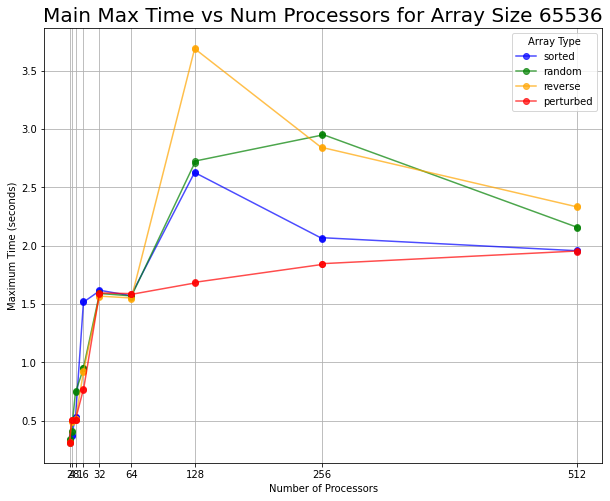

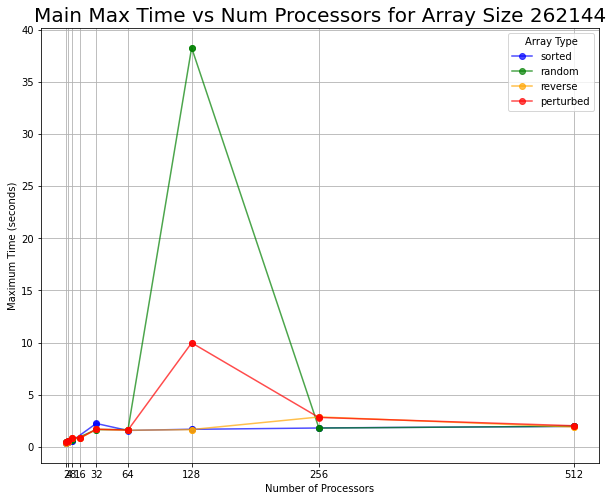

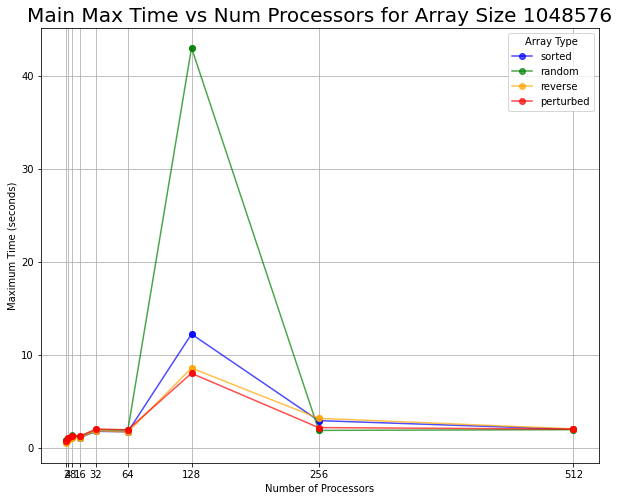

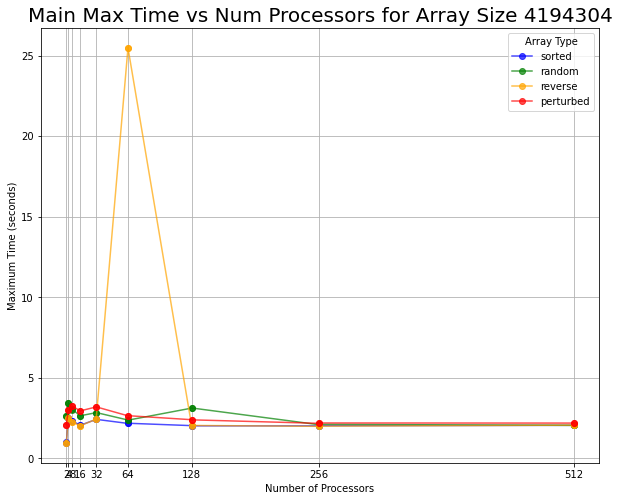

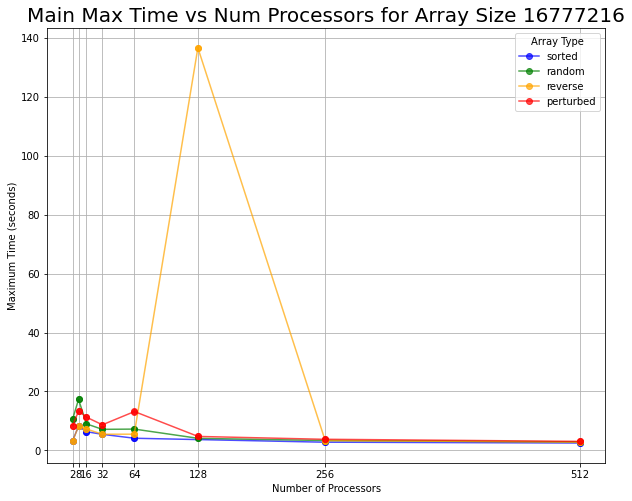

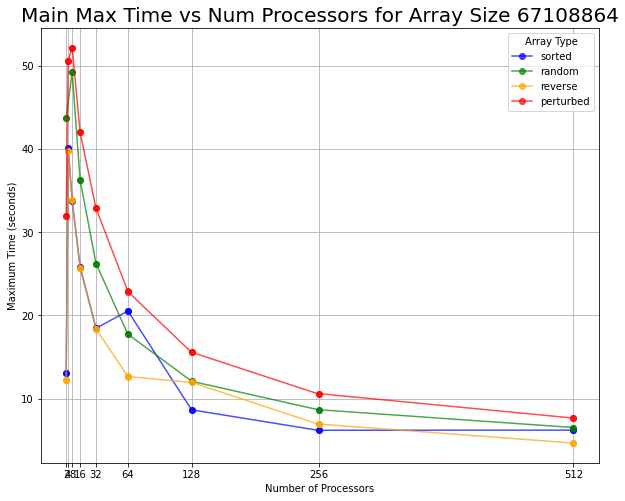

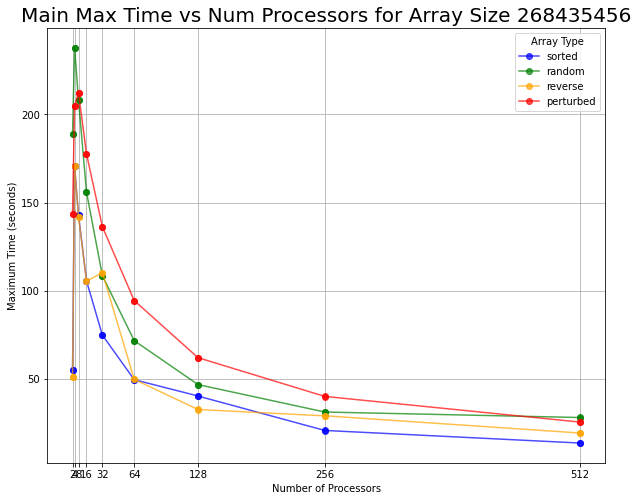

In [17]:
# Main - strong scaling

import pandas as pd
import matplotlib.pyplot as plt


array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for array_size in array_sizes:

    filtered_df = main_final_df[main_final_df['input_size'] == array_size]


    colors = {
        'sorted': 'blue',
        'random': 'green',
        'reverse': 'orange',
        'perturbed': 'red'
    }


    plt.figure(figsize=(10, 8))

    
    for array_type, color in colors.items():
        type_data = filtered_df[filtered_df['input_type'] == array_type]

        type_data = type_data.sort_values('num_procs')

        plt.plot(type_data['num_procs'], type_data['Max time/rank'], 
                 color=color, label=array_type, alpha=0.7, marker='o') 

    plt.title(f'Main Max Time vs Num Processors for Array Size {array_size}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Maximum Time (seconds)')
    plt.xticks(filtered_df['num_procs'].unique())
    plt.grid()
    plt.legend(title='Array Type')
    plt.savefig(f'img/main_strong_max_{array_size}.png', facecolor='white')
    plt.show()


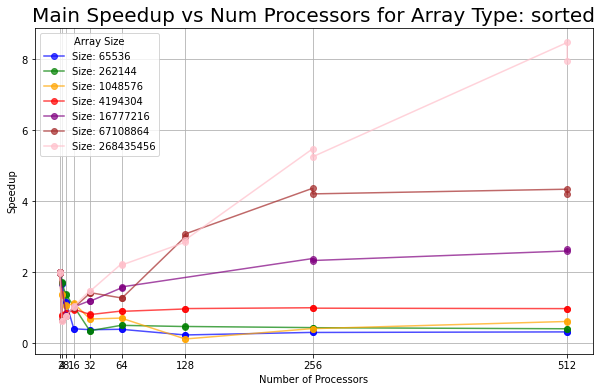

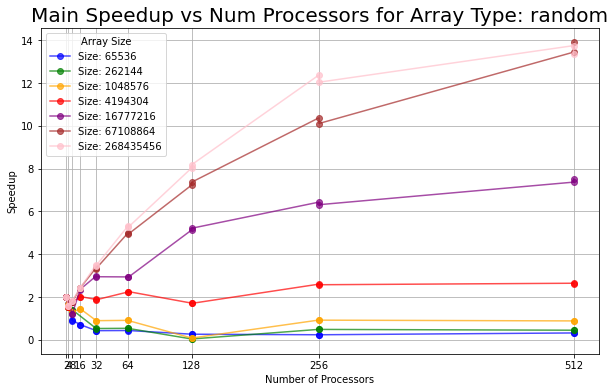

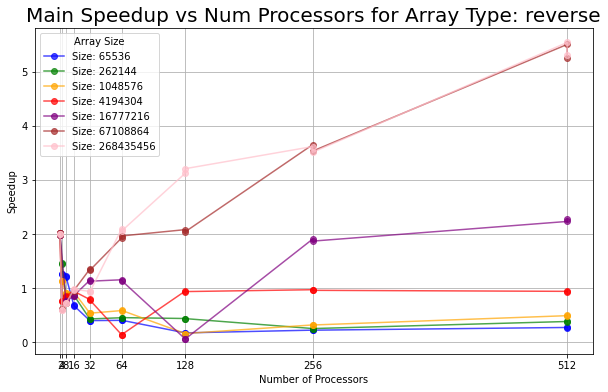

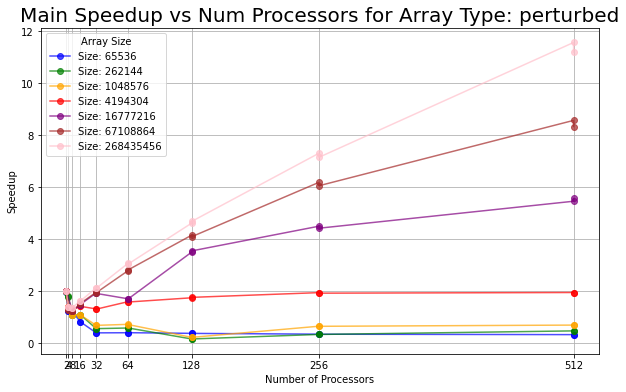

In [18]:
# Main - strong scaling speedup

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [2**i for i in range(16, 29)] 
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}


speedup_df = pd.DataFrame()

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = main_final_df[main_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue
        
        single_proc_time = type_data[type_data['num_procs'] == 2]['Avg time/rank'].mean() * 2
        if pd.isna(single_proc_time):
            continue
        
        type_data.loc[:, 'Speedup'] = single_proc_time / type_data['Avg time/rank'] 
        
        speedup_df = pd.concat([speedup_df, type_data])
        
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Speedup'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o')  

    plt.title(f'Main Speedup vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Speedup')
    plt.xticks(sorted(type_data['num_procs'].unique()))  
    plt.grid()
    plt.legend(title='Array Size')  
    plt.savefig(f'img/main_speedup_avg_{array_type}.png', facecolor='white')
    plt.show() 



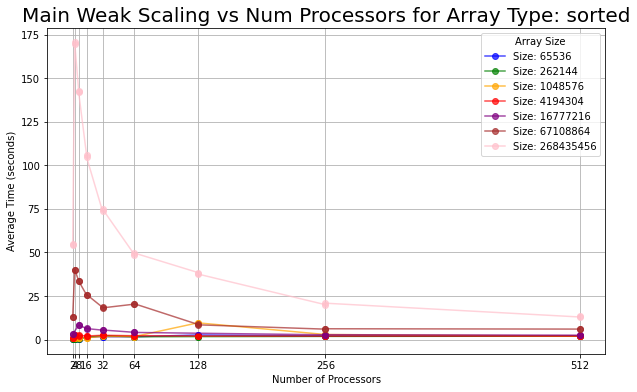

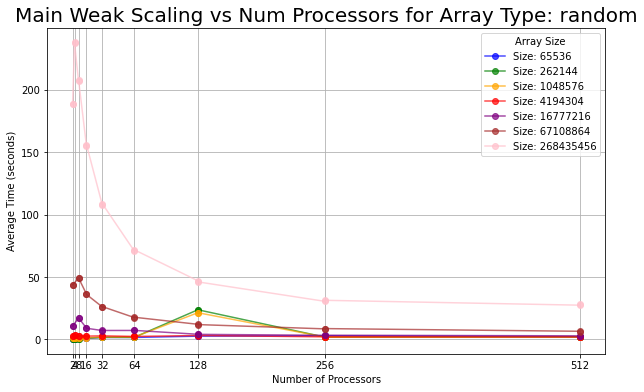

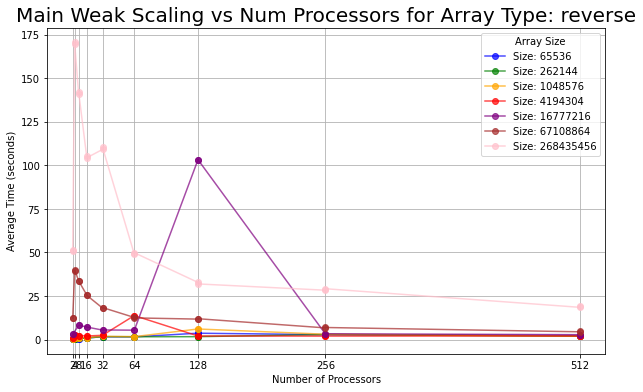

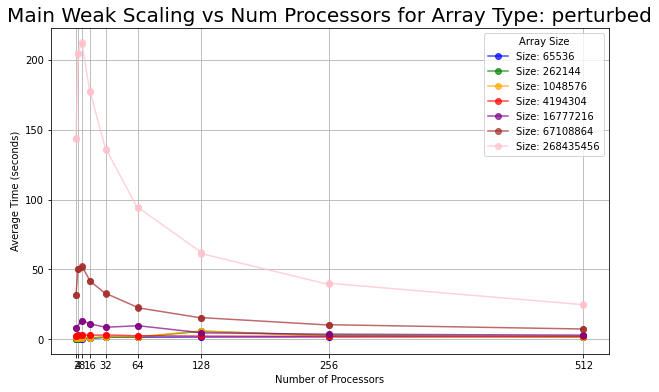

In [19]:
# Main - weak scaling

import pandas as pd
import matplotlib.pyplot as plt

array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
array_types = ['sorted', 'random', 'reverse', 'perturbed']

colors = {
    65536: 'blue',        # 2^16
    262144: 'green',      # 2^18
    1048576: 'orange',    # 2^20
    4194304: 'red',       # 2^22
    16777216: 'purple',    # 2^24
    67108864: 'brown',     # 2^26
    268435456: 'pink'      # 2^28
}

for array_type in array_types:
    plt.figure(figsize=(10, 6))
    
    for array_size in array_sizes:
        filtered_df = main_final_df[main_final_df['input_size'] == array_size]
        type_data = filtered_df[filtered_df['input_type'] == array_type].copy()
        
        if type_data.empty:
            continue 
        
    
        type_data = type_data.sort_values('num_procs')
        
        plt.plot(type_data['num_procs'], type_data['Avg time/rank'], 
                 color=colors.get(array_size, 'black'),  
                 label=f'Size: {array_size}', 
                 alpha=0.7, marker='o') 

    plt.title(f'Main Weak Scaling vs Num Processors for Array Type: {array_type}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(sorted(type_data['num_procs'].unique()))
    plt.grid()
    plt.legend(title='Array Size') 
    plt.savefig(f'img/main_weak_avg_{array_type}.png', facecolor='white')
    plt.show() 


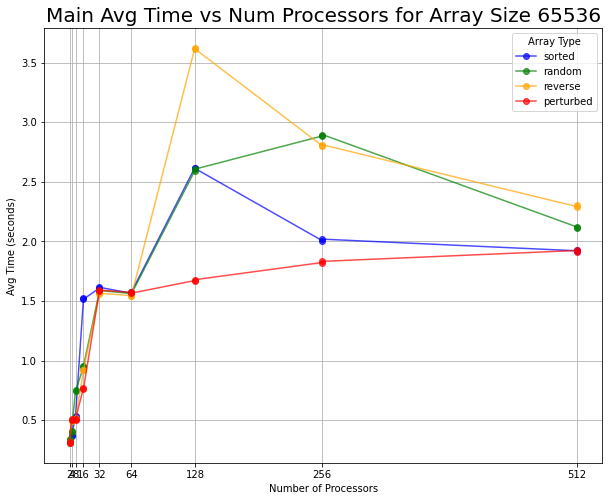

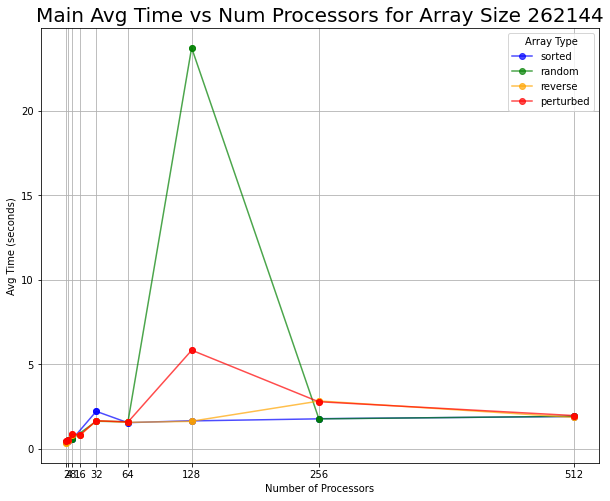

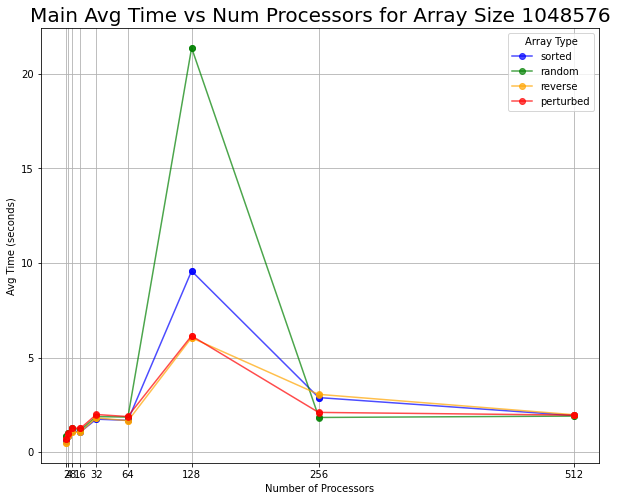

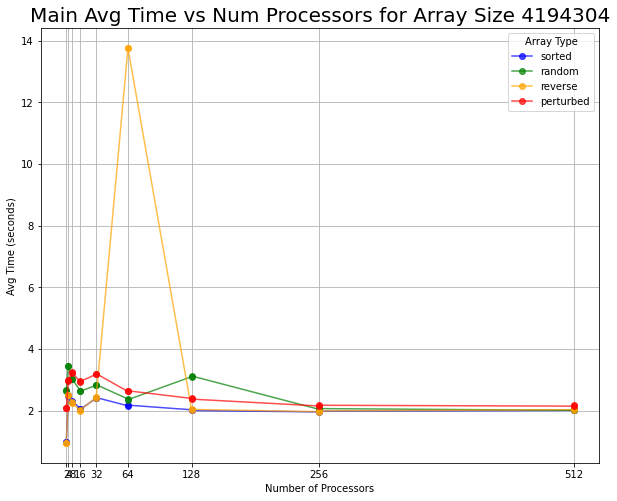

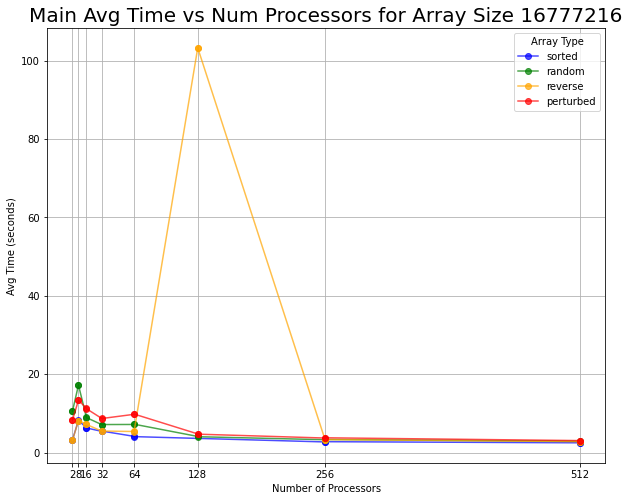

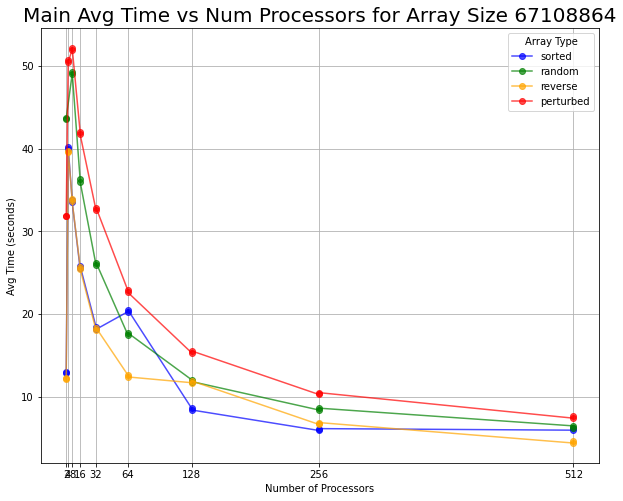

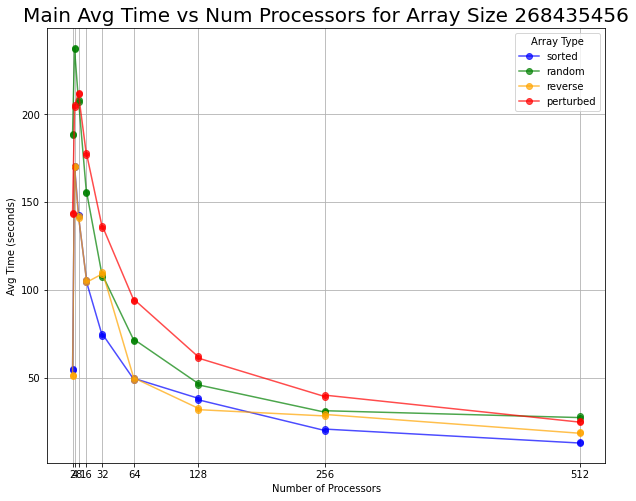

In [20]:
# Main - strong scaling avg

import pandas as pd
import matplotlib.pyplot as plt


array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for array_size in array_sizes:

    filtered_df = main_final_df[main_final_df['input_size'] == array_size]


    colors = {
        'sorted': 'blue',
        'random': 'green',
        'reverse': 'orange',
        'perturbed': 'red'
    }


    plt.figure(figsize=(10, 8))

    
    for array_type, color in colors.items():
        type_data = filtered_df[filtered_df['input_type'] == array_type]

        type_data = type_data.sort_values('num_procs')

        plt.plot(type_data['num_procs'], type_data['Avg time/rank'], 
                 color=color, label=array_type, alpha=0.7, marker='o') 

    plt.title(f'Main Avg Time vs Num Processors for Array Size {array_size}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Avg Time (seconds)')
    plt.xticks(filtered_df['num_procs'].unique())
    plt.grid()
    plt.legend(title='Array Type')
    plt.show()


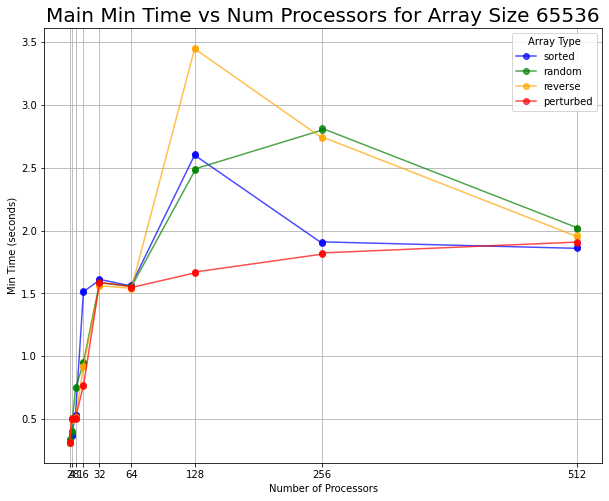

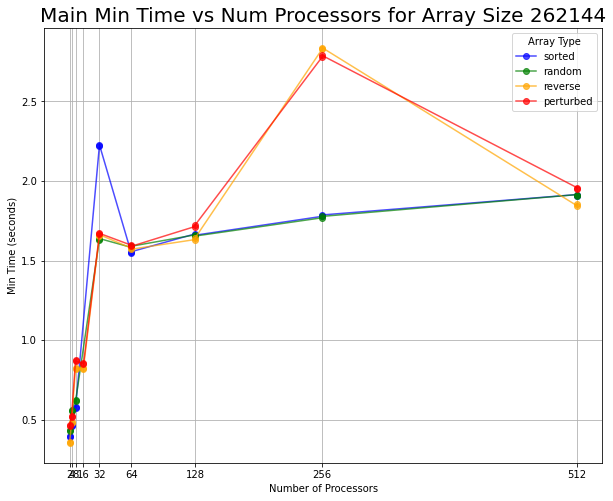

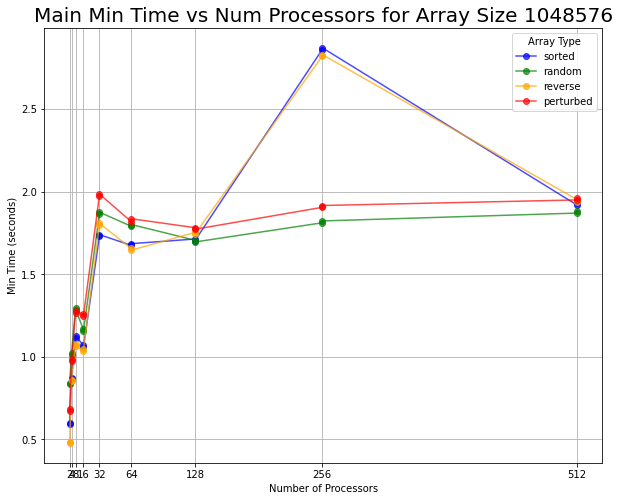

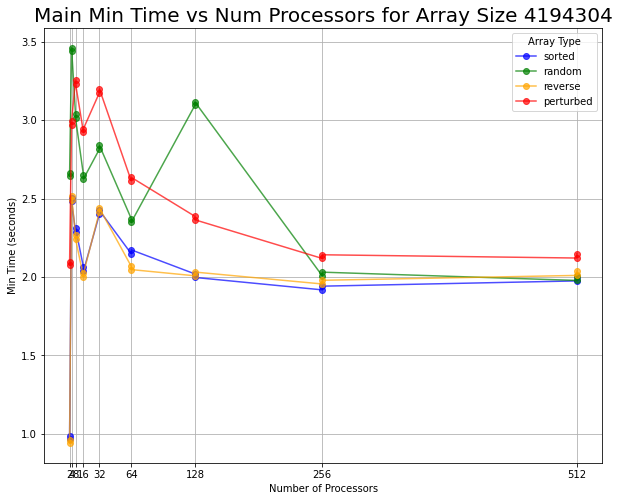

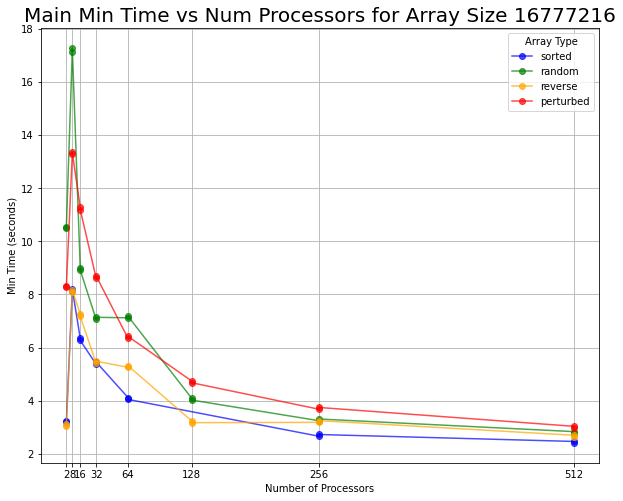

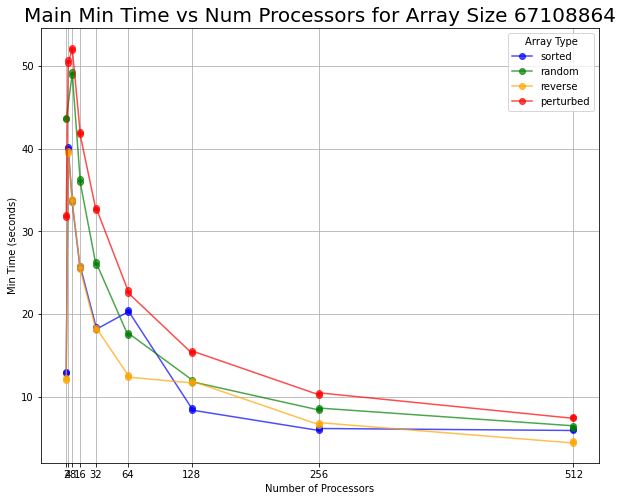

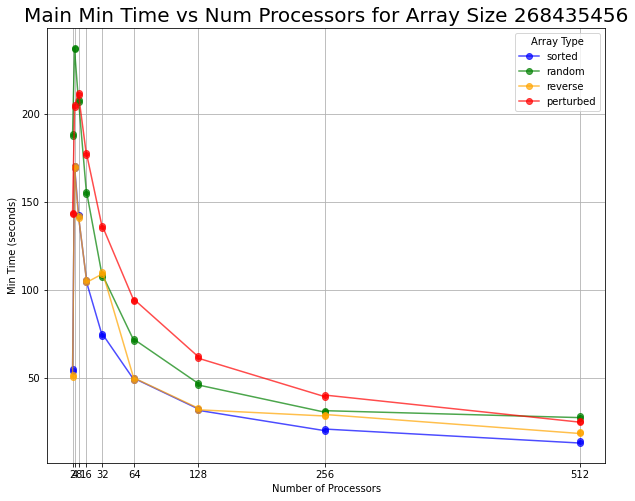

In [21]:
# Main - strong scaling min

import pandas as pd
import matplotlib.pyplot as plt


array_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]

for array_size in array_sizes:

    filtered_df = main_final_df[main_final_df['input_size'] == array_size]


    colors = {
        'sorted': 'blue',
        'random': 'green',
        'reverse': 'orange',
        'perturbed': 'red'
    }


    plt.figure(figsize=(10, 8))

    
    for array_type, color in colors.items():
        type_data = filtered_df[filtered_df['input_type'] == array_type]

        type_data = type_data.sort_values('num_procs')

        plt.plot(type_data['num_procs'], type_data['Min time/rank'], 
                 color=color, label=array_type, alpha=0.7, marker='o') 

    plt.title(f'Main Min Time vs Num Processors for Array Size {array_size}', fontsize=20)
    plt.xlabel('Number of Processors')
    plt.ylabel('Min Time (seconds)')
    plt.xticks(filtered_df['num_procs'].unique())
    plt.grid()
    plt.legend(title='Array Type')
    plt.show()
